<h1 style = 'text-align:center'> CAPSTONE PROJECT : <br> Segmenting and clustering Toronto Neighborhood</h1>

## Introduction
In this project, we will explore, segment and cluster Toronto neighborhoods.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Gettind the Neighborhoods data</a>

2. <a href="#item2">Explore Neighborhoods in Toronto City</a>

3. <a href="#item4">Segment and Cluster Neighborhoods</a>
</font>
</div>

let's import the libraries needed for this project

In [27]:
#importing libraries 
import numpy as np # useful for mathematical operation and data manupulation

import pandas as pd # for data analysis 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

#!conda install -c conda-forge geopy --yes ## uncomment if 
from geopy.geocoders import Nominatim #to convert adress into latitude longitude

import requests #to get url 
from pandas import json_normalize # to transform json into pandas dataframe

#pip install folium 
import folium #map rendering library

#!pip install beautifulsoup4 # webscrapping library
import bs4 # for parsing html


# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('library downloaded and imported')

library downloaded and imported


<h2 style = "margin-top: 20px"> 1.  Getting the Neighborhoods data </h2>

The first step for any project is to get the right data. In the context of if this capstone project, we suppose the data is not readily avalaible for us. So we use web scrapping techniques specially `BeautifulSoup` to scrape a wikipedia [page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) that contains the useful informations. Note that a dataset on the toronto neighborhood has been published in 2020 and can be found [here](https://open.toronto.ca/dataset/neighbourhood-profiles/)

We follow these steps in this section : 
- Download the neighborhoods from wikipedia
- Clean the data
- Get location coordinates for each neighborhood

#### Download the neighborhood data from Wikipedia
Although it is possible to scrape a url using `pandas`, I choose to use `BeautifulSoup` library, because I find it simple and very powerful. 
Below, we use `requests` to get the url, and `Beautifulsoup` to scrape the data. 

In [28]:
wikipedia_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

#get url with requests
html_doc = requests.get(wikipedia_url)  

#test if there is no error 
html_doc.raise_for_status  

<bound method Response.raise_for_status of <Response [200]>>

we then parse the request and extract the table that contains the neighborhoods informations

In [29]:
# instantiate a soup object
soup_wiki_page = bs4.BeautifulSoup(html_doc.text) 

#find all ``tr`` tags within the ``table`` tag
soup_wiki_table = soup_wiki_page.select('.wikitable tr') 

columns = ['PostalCode', 'Borough', 'Neighborhood'] 
#instantiate a dataframe
df_neighborhood = pd.DataFrame(columns= columns)
df_neighborhood

,PostalCode,Borough,Neighborhood


In [30]:
for row in soup_wiki_table[1:]:
    row = list(row.stripped_strings)
    postal_code = row[0]
    borough = row[1]
    neighborhood = row[2]
    
    
    df_neighborhood = df_neighborhood.append({'PostalCode': postal_code,
                                              'Borough': borough,
                                              'Neighborhood': neighborhood}, ignore_index=True)
    
df_neighborhood.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


let's examine the dataset

In [31]:
print('There are {} rows in the raw data'.format(len(df_neighborhood)))

# check if how many row has 'Not assigned' neighborhood but 'assigned' Borough
neighbor_not_assign = len(df_neighborhood[(df_neighborhood['Borough'] == 'Not assigned') 
                            & (df_neighborhood['Neighborhood'] != 'Not assigned')])

neighbor_borough_not_assign = len(df_neighborhood[(df_neighborhood['Borough'] == 'Not assigned') 
                                    & (df_neighborhood['Neighborhood'] == 'Not assigned')])

print(f'there is {neighbor_not_assign} row where neighborhood is not assigned and borough is assigned')
print(f'There are {neighbor_borough_not_assign} rows where both neighborhood and borough are not assigned')

There are 180 rows in the raw data
there is 0 row where neighborhood is not assigned and borough is assigned
There are 77 rows where both neighborhood and borough are not assigned


#### Data cleaning

In [32]:
# drop rows where there are missing values
df_neighborhood = df_neighborhood.replace('Not assigned',np.nan).dropna().reset_index(drop=True)
df_neighborhood.head(12)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [33]:
df_neighborhood.shape

(103, 3)

#### Get location coordinates for each neighborhood
For the purpose of our analysis, we need to complete the data with coordinates of each neighborhood. We got a csv that have what we need

In [34]:
coordinates = pd.read_csv('Geospatial_Coordinates.csv')
coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [35]:
#rename the coordinate columns to match df_neighborhood
coordinates.rename(columns={'Postal Code': 'PostalCode'}, inplace = True )

# join the two dataframes
df_neighborhood = df_neighborhood.join(coordinates.set_index('PostalCode'), on= 'PostalCode')


df_neighborhood.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [38]:
print('There are {} unique boroughs in toronto'.format(len(df_neighborhood.Borough.unique())))

There are 10 unique boroughs in toronto


<p class='alert alert-info'>Note : Neighborhoods are grouped by postal code, so there are rows that combine multiple neighborhood separated with a comma</p>

<h2 style = "margin-top: 20px"> 2.  Explore neighborhoods </h2>

In this section we will do the following steps :
- Visualise toronto map using folium
- Get nearby venues of each neighborhood


#### Visualize Toronto with each neighborhood

First let's get the latitude and longitude of Toronto city

In [39]:
#get the location of toronto.
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent = 'To-explorer')
location = geolocator.geocode(address)

lat = location.latitude
lng = location.longitude

print('The geograpical coordinates of Toronto City are {}, {}'.format(lat, lng))

The geograpical coordinates of Toronto City are 43.6534817, -79.3839347


We can now use `Folium` library to plot the map. 

In [51]:
#create Toronto map
map_toronto = folium.Map(location=[lat, lng], zoom_start=10)

# add neighborhoods as markers on the map
for lat, lng, borough, neighborhood in zip(df_neighborhood['Latitude'], 
                                                        df_neighborhood['Longitude'],
                                                        df_neighborhood['Borough'],
                                                       df_neighborhood['Neighborhood']):
    
    label =  borough + ' :'+'\n' + neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(location= [lat, lng],
                       radius = 5, 
                       color = 'blue',
                       fill = True,
                       fill_color = 'skyblue',
                       fill_opacity = 0.7,
                       parse_html=False,
                       popup=label).add_to(map_toronto)

print('Click on circles to show the borough and the neighborhoods')
map_toronto

Click on circles to show the borough and the neighborhoods


Now let's get the nearby venues of each neighborhood

For visualization purpose, we continue with the neighborhood which contains only the word **Toronto**.

In [66]:
central_toronto = df_neighborhood[df_neighborhood['Borough'].str.contains('Toronto')].reset_index(drop=True)
central_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [67]:
#create Toronto map
map_toronto = folium.Map(location=[lat, lng], zoom_start=11)

# add neighborhoods as markers on the map
for lat, lng, borough, neighborhood in zip(central_toronto['Latitude'], 
                                                        central_toronto['Longitude'],
                                                        central_toronto['Borough'],
                                                       central_toronto['Neighborhood']):
    
    label =  borough + ' :'+'\n' + neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(location= [lat, lng],
                       radius = 5, 
                       color = 'blue',
                       fill = True,
                       fill_color = 'skyblue',
                       fill_opacity = 0.7,
                       parse_html=False,
                       popup=label).add_to(map_toronto)

print('Click on circles to show the borough and the neighborhoods')
map_toronto

Click on circles to show the borough and the neighborhoods


#### Get the nearby venues of each neighborhoods

We will `foursquare API` for this step. 

In [57]:
#import credentials 
from secret import CLIENT_ID, CLIENT_SECRET, VERSION

In [69]:
LIMIT = 100

# %load functions/foursquare.py
def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Neighborhood Latitude',
                  'Neighborhood Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category']

    return(nearby_venues)


In [72]:
central_toronto_venues = getNearbyVenues(names= central_toronto['Neighborhood'],
                                 latitudes= central_toronto['Latitude'],
                                 longitudes= central_toronto['Longitude'])


Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


In [74]:
central_toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",18,18,18,18,18,18
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",14,14,14,14,14,14
Central Bay Street,65,65,65,65,65,65
Christie,17,17,17,17,17,17
Church and Wellesley,76,76,76,76,76,76
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,35,35,35,35,35,35


In [75]:
print('There are {} uniques categories.'.format(len(central_toronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


#### Analyze each neighborhood

In [76]:
#one hot encoding 
central_toronto_onehot = pd.get_dummies(central_toronto_venues["Venue Category"], prefix='', prefix_sep = '')

#put back in Neighborhood column to the dataframe
central_toronto_onehot['Neighborhood'] = central_toronto_venues['Neighborhood']

#bring back neighborhood column in the first place
fixed_columns = [central_toronto_onehot.columns[-1]] + list(central_toronto_onehot.columns[:-1])
central_toronto_onehot = central_toronto_onehot[fixed_columns]

#groupe by neighborhood
central_toronto_grouped = central_toronto_onehot.groupby("Neighborhood").mean().reset_index()

central_toronto_grouped.shape

(39, 236)

let's write a function to sort the venues category in a descending order

In [77]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [79]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = central_toronto_grouped['Neighborhood']

for ind in np.arange(central_toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(central_toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Café,Beer Bar,Bakery,Seafood Restaurant,Cheese Shop,Restaurant,Jazz Club,Shopping Mall
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Nightclub,Convenience Store,Grocery Store,Gym,Performing Arts Venue,Pet Store,Furniture / Home Store
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Smoke Shop,Recording Studio,Fast Food Restaurant,Farmers Market,Auto Workshop,Burrito Place,Brewery,Restaurant,Pizza Place
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Coffee Shop,Airport Terminal,Boat or Ferry,Sculpture Garden,Rental Car Location,Harbor / Marina,Boutique,Airport Gate
4,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Japanese Restaurant,Café,Thai Restaurant,Middle Eastern Restaurant,Salad Place,Burger Joint,Bubble Tea Shop


## 3. Clustering and segmenting

In this section we will proceed with the following steps:
- find the correct *k* for *k*-means clustering
- cluster the neighborhood 
- apply the cluster and segment

#### find the correct k for k-means clustering

In [80]:
central_toronto_clustering = central_toronto_grouped.drop('Neighborhood', 1)

In [130]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k, n_init=30).fit(central_toronto_clustering)
  labels = kmeans.labels_
  sil.append(silhouette_score(central_toronto_clustering, labels, metric = 'euclidean'))


Text(0.5, 1.0, 'Choosing the correct k with Silhoute score')

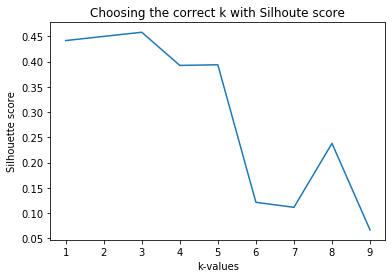

In [131]:
import matplotlib.pyplot as plt

plt.plot(range(1,kmax), sil)
plt.ylabel('Silhouette score')
plt.xlabel('k-values')
plt.title('Choosing the correct k with Silhoute score')

With the silhouette score, k value with highest pic i.e. **k = 3**

In [138]:
#set k number for clustering 
kclusters = 7

#fit the data into kmean algorithm
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(central_toronto_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 5, 1, 1, 1, 1], dtype=int32)

In [139]:
# add clustering labels
neighborhoods_venues_sorted.drop(columns = 'Cluster Labels', inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

central_toronto_merged = central_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
central_toronto_merged = central_toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


central_toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Restaurant,Café,Theater,Cosmetics Shop,Shoe Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Diner,Sushi Restaurant,Yoga Studio,College Auditorium,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Clothing Store,Coffee Shop,Italian Restaurant,Café,Cosmetics Shop,Bubble Tea Shop,Japanese Restaurant,Middle Eastern Restaurant,Pizza Place,Diner
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Café,Coffee Shop,American Restaurant,Restaurant,Gastropub,Cocktail Bar,Department Store,Creperie,Lingerie Store,Moroccan Restaurant
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Pub,Trail,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center


In [140]:
# create map
map_clusters = folium.Map(location=[lat, lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(central_toronto_merged['Latitude'], central_toronto_merged['Longitude'], central_toronto_merged['Neighborhood'], central_toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters